# How to: Use `jackknify` for line finding. 

`jackknify` can be used in a variaty of ways. Here, we show how to use the jackknifed data sets for inference of a line detection. According to JWST data, In the ALMA data we have been working with, there should be [OIII] emission coming from a galaxy which some 14 Billion light years away. Let's see if we can find it, or if it is undistinguishable from noise.

The line finding is done with a code named [Source EXtractor](https://www.astromatic.net/software/sextractor/). Source extractor is integrated in a Python interface through the [`Interferopy` package](https://interferopy.readthedocs.io/en/latest/). Sadly, Interferopy is restricts the usage of Python version (>3.6 and <3.10), meaning we can't integrate it with `jackknify` since `jackknify` works in the visibillity plane, therefore it needs to use the package `casatasks` which limits the Python version to Python=3.6-3.8. Therefore, we ran the linefinding seperately, but you can you find the output catalogs also on the [google drive](https://drive.google.com/file/d/1FlQNwy7VtAk0zcFfdW5tMY2aGKivxlyR/view?usp=sharing) and the script we used to generate the outputs in the same folder as the tutorials. 

Let's first load in everythinbg. 

### Load in 

In [1]:
import numpy as np
from scipy import stats
from astropy import units as u
from astropy.coordinates import SkyCoord

import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True

In [2]:
# load in all catalogs
# change directory depending on where you downloaded it
path0 = '../../output/findclumps/Glass-z13/' 
path1 = '../../output/findclumps/Glass-z13_Jacked_seed42/'
path2 = '../../output/findclumps/Glass-z13_Jacked_seed142/'
path3 = '../../output/findclumps/Glass-z13_Jacked_seed242/'
path4 = '../../output/findclumps/Glass-z13_Jacked_seed243/'
path5 = '../../output/findclumps/Glass-z13_Jacked_seed244/'

cat_N = 'findlcumps_clumpsN_minSNR_-2.cat'
cat_P = 'findlcumps_clumpsP_minSNR_-2.cat'

data_real_N = ascii.read(path0+cat_N)
data_jack1_N = ascii.read(path1+cat_N)
data_jack2_N = ascii.read(path2+cat_N)
data_jack3_N = ascii.read(path3+cat_N)
data_jack4_N = ascii.read(path4+cat_N)
data_jack5_N = ascii.read(path5+cat_N)

data_real_P = ascii.read(path0+cat_P)
data_jack1_P = ascii.read(path1+cat_P)
data_jack2_P = ascii.read(path2+cat_P)
data_jack3_P = ascii.read(path3+cat_P)
data_jack4_P = ascii.read(path4+cat_P)
data_jack5_P = ascii.read(path5+cat_P)

This is how a single catalog looks like. 

In [3]:
data_jack5_P

RA,DEC,FREQ_GHZ,X,Y,SNR,FLUX_MAX,BINNING
float64,float64,float64,float64,float64,float64,float64,int64
3.49878,-30.32503,253.8213,725.7,192.8,2.12,0.000568,3
3.4994,-30.32519,253.8213,82.2,1.4,1.52,0.000409,3
3.49895,-30.32447,253.8213,547.7,870.8,2.38,0.000637,3
3.49947,-30.32434,253.8213,8.8,1020.9,2.03,0.000543,3
3.49931,-30.32443,253.8213,178.3,913.3,1.45,0.000389,3
3.49914,-30.32455,253.8213,357.5,774.6,1.71,0.000459,3
3.49948,-30.32455,253.8213,5.0,775.0,1.66,0.000444,3
3.49932,-30.32458,253.8213,169.2,734.1,2.48,0.000664,3
3.49861,-30.32458,253.8213,896.9,736.1,2.74,0.000734,3


## Plot sampled probabillity functions

As explained in [Vio & Andreani 2016](https://arxiv.org/abs/1602.02392), the underlying distribution that sets the likelihood of false detection is the distribution of peaks of a smoothed (close to) Gaussian random field. With the jackedknifed measurment sets we effectively resample this distribution. This is more complete and more acurately than, for isntance, using the distribution of negative peak values as used in [Walter+2016](https://arxiv.org/abs/1607.06768). 

### Comparing the two noise distribution
Below we show the comparison between the linefind results done on the jackknifed cubes (with postive and negative peak values) and the distribution of negative peak values from the real data.

In [4]:
coord_JWST = (3.498985, -30.324767)
c1 = SkyCoord(coord_JWST[0]*u.deg, coord_JWST[1]*u.deg, frame='icrs')

# mask selection first
data_jack_RA_P = np.hstack((data_jack1_P['RA'], data_jack2_P['RA'], data_jack3_P['RA'], data_jack4_P['RA'], data_jack5_P['RA']))
data_jack_DC_P = np.hstack((data_jack1_P['DEC'], data_jack2_P['DEC'], data_jack3_P['DEC'], data_jack4_P['DEC'], data_jack5_P['DEC']))
c2_jack_P      = SkyCoord(ra = data_jack_RA_P*u.deg, dec = data_jack_DC_P*u.deg, frame='icrs')
sep_jack_P     = c1.separation(c2_jack_P).to(u.arcsec).value
mask_jack_P    = sep_jack_P < 0.5

data_real_RA_P = data_real_P['RA']
data_real_DC_P = data_real_P['DEC']
c2_real_P      = SkyCoord(ra = data_real_RA_P*u.deg, dec = data_real_DC_P*u.deg, frame='icrs')
sep_real_P     = c1.separation(c2_real_P).to(u.arcsec).value
mask_real_P    = sep_real_P < 0.5


data_jack_RA_N = np.hstack((data_jack1_N['RA'], data_jack2_N['RA'], data_jack3_N['RA'], data_jack4_N['RA'], data_jack5_N['RA']))
data_jack_DC_N = np.hstack((data_jack1_N['DEC'], data_jack2_N['DEC'], data_jack3_N['DEC'], data_jack4_N['DEC'], data_jack5_N['DEC']))
c2_jack_N      = SkyCoord(ra = data_jack_RA_N*u.deg, dec = data_jack_DC_N*u.deg, frame='icrs')
sep_jack_N     = c1.separation(c2_jack_N).to(u.arcsec).value
mask_jack_N    = sep_jack_N < 0.5

data_real_RA_N = data_real_N['RA']
data_real_DC_N = data_real_N['DEC']
c2_real_N      = SkyCoord(ra = data_real_RA_N*u.deg, dec = data_real_DC_N*u.deg, frame='icrs')
sep_real_N     = c1.separation(c2_real_N).to(u.arcsec).value
mask_real_N    = sep_real_N < 0.5

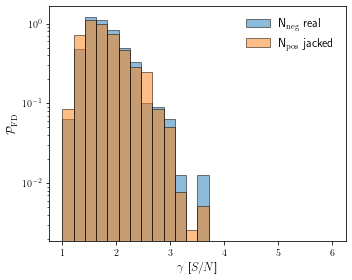

In [5]:
# append the jackknifed cubed into one sample
data_jack_P = np.hstack((data_jack1_P['SNR'], data_jack2_P['SNR'], data_jack3_P['SNR'], data_jack4_P['SNR'], data_jack5_P['SNR']))
data_jack_N = np.hstack((data_jack1_N['SNR'], data_jack2_N['SNR'], data_jack3_N['SNR'], data_jack4_N['SNR'], data_jack5_N['SNR']))

plt.figure(figsize=(5,4))
plt.hist(data_real_N['SNR'][mask_real_N], bins = np.linspace(1, 6, 25), density = True, alpha = 0.5, edgecolor='black', label = r'N$_{\rm neg}$ real', color = 'C0')
plt.hist(data_jack_P[mask_jack_P],        bins = np.linspace(1, 6, 25), density = True, alpha = 0.5, edgecolor='black', label = r'N$_{\rm pos}$ jacked', color = 'C1')

plt.xlabel(r'$\gamma$ [$S/N$]', fontsize = 12)
plt.ylabel(r'$\mathcal{P}_{\rm FD}$', fontsize = 12)
plt.legend(frameon=False, fontsize = 12)

plt.semilogy()
plt.tight_layout()
plt.savefig('../../plots/neg_vs_pos.pdf', dpi = 300)
plt.show()

We can do a quick statistical to verify if the two distributions are drawn from the same distribution. 

In [6]:
print('p-value = {:.5f}'.format(stats.ks_2samp(data_real_N['SNR'][mask_real_N] ,data_jack_P[mask_jack_P]).pvalue))

p-value = 0.03565


The null hypothesis that the two random samples come from the same distribution can be rejected by only 

### Detection inference

Now let's compare the noise distribution --- drawn fromt the jackknifed data sets --- with the positive peak distribution of the real initial data set. Since the astronomical signal is positive, any excess in peaks distribution in the data can be considered true.

Further, we have prior information on the redshift and source position. Therefore, we use Bayes theorom to get the final posterior distribution. First we plot the initial PDF

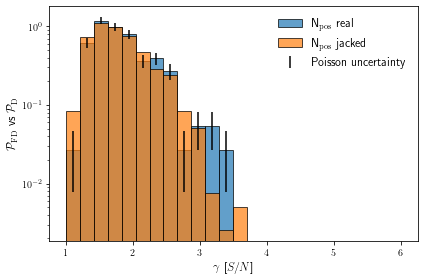

In [7]:
# Density vs SNR
# --------------

# append the jackknifed cubed into one sample
data_jack_P = np.hstack((data_jack1_P['SNR'], data_jack2_P['SNR'], data_jack3_P['SNR'], data_jack4_P['SNR'], data_jack5_P['SNR']))

plt.figure(figsize=(6,4))
bins_D  = plt.hist(data_real_P['SNR'][mask_real_P], bins = np.linspace(1, 6, 25), density = True, alpha = 0.7, edgecolor='black', label = r'N$_{\rm pos}$ real')
bins_FD = plt.hist(data_jack_P[mask_jack_P], bins = np.linspace(1, 6, 25), density = True, alpha = 0.7, edgecolor='black', label = r'N$_{\rm pos}$ jacked')

# plotting the Poisson uncertainty
bin_widths = bins_D[1][1] - bins_D[1][0]
bin_centers = 0.5 * (bins_D[1][1:] + bins_D[1][:-1])
raw_counts, _ = np.histogram(data_real_P['SNR'][mask_real_P], bins=np.linspace(1, 6, 25))
uncertainties = np.sqrt(raw_counts)
density_uncertainties = uncertainties / (len(data_real_P['SNR'][mask_real_P]) * bin_widths)

plt.errorbar(bin_centers, bins_D[0], yerr=density_uncertainties, fmt=' ', color='k', label='Poisson uncertainty')


plt.xlabel(r'$\gamma$ [$S/N$]', fontsize = 12)
plt.ylabel(r'$\mathcal{P}_{\rm FD}$ vs $\mathcal{P}_{\rm D}$', fontsize = 12)
plt.legend(frameon=False, fontsize = 12)
plt.semilogy()

plt.tight_layout()
plt.savefig('../../plots/pos_vs_pos_zoom.pdf', dpi = 300)
plt.show()